In [1]:
from functools import cache

import torch
import torch.nn as nn
import numpy as np
import math

class TimeEmbedding(nn.Module):
    def __init__(self, harmonics_dim: int, t_emb_dim: int, hidden_dim: int = 64):
        super(TimeEmbedding, self).__init__()

        pe = torch.arange(1, harmonics_dim + 1).float().unsqueeze(0) * 2 * math.pi
        self.t_model = nn.Sequential(
            nn.Linear(2 * harmonics_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, t_emb_dim),
            nn.GELU(),
        )
        self.register_buffer("pe", pe)

    def forward(self, t: float = None):
        """
        Arguments:
            t: float
        """
        t_sin = (t * self.pe).sin()
        t_cos = (t * self.pe).cos()
        t_emb = torch.cat([t_sin, t_cos], dim=-1)
        return self.t_model(t_emb)


class StateEmbedding(nn.Module):
    def __init__(self, s_dim: int, hidden_dim: int = 64, s_emb_dim: int = 64):
        super(StateEmbedding, self).__init__()

        self.x_model = nn.Sequential(
            nn.Linear(s_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, s_emb_dim),
            nn.GELU(),
        )

    def forward(self, s):
        return self.x_model(s)

class NeuralDrift(nn.Module): # Feedback
    def __init__(self, s_dim: int, harmonics_dim: int = 128, t_emb_dim: int = 128, hidden_dim: int = 128, s_emb_dim: int = 128, mlp_hidden_dim: int = 128):
        super(NeuralDrift, self).__init__()
        
        self.state_embedder = StateEmbedding(s_dim, hidden_dim, s_emb_dim)
        self.time_embedder = TimeEmbedding(harmonics_dim, t_emb_dim, hidden_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(s_emb_dim + t_emb_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, s_dim)
        )
    
    def forward(self, x, t): # Feedback
          
        x_embedded = self.state_embedder(x)
        t_embedded = self.time_embedder(t)
        
        t_embedded = t_embedded.expand(x_embedded.size(0), -1)
        
        combined = torch.cat([x_embedded, t_embedded], dim=-1)
        output = self.mlp(combined)
        
        return output.squeeze(-1)

In [2]:
import torch
import numpy as np
import random

from energy.neural_drift import NeuralDrift

@torch.enable_grad()
def get_reward_and_gradient(x, log_reward):
    x = x.requires_grad_(True)
    log_r_x = log_reward(x)
    log_r_grad = torch.autograd.grad(log_r_x.sum(), x, create_graph=True)[0]

    return log_r_x, log_r_grad


def langevin_proposal(neural_drift, x, log_r_grad, step_size, sigma):
    
    dt = step_size 
    transition_mean = (2*sigma*(neural_drift) + (sigma**2)*log_r_grad) * dt 
    transition_std = sigma * np.sqrt(2 * dt) 
    
    x_new = ( #Euler-Maruyama
        x
        + transition_mean
        + transition_std * torch.randn_like(x, device=x.device)
    )
    
    return x_new, transition_mean, transition_std
    
def compute_transition_log_prob(x, x_new, transition_mean, transition_std, bwd_drift): 
    variance = torch.tensor(transition_std**2, device=x.device)
    
    log_p_transition_fwd = ( #P(X_{t+1} | X_t)
        -((x - transition_mean) ** 2).sum(dim=-1) / (2 * variance) 
        - 0.5 * x.shape[1] * torch.log(2 * torch.pi * variance)
    )
    
    log_p_transition_bwd = ( #P(X_t | X_{t+1})
        -((x_new + bwd_drift) ** 2).sum(dim=-1) / (2 * variance) 
        - 0.5 * x.shape[1] * torch.log(2 * torch.pi * variance)
    )   
    
    log_importance_weight = log_p_transition_fwd - log_p_transition_bwd
    
    return log_p_transition_fwd, log_importance_weight


def one_step_langevin_dynamic(neural_drift, x, time, log_reward, step_size, sigma, do_correct=False):
    log_r_old, r_grad_old = get_reward_and_gradient(x, log_reward)
    drift_value = neural_drift(x, time)
    
    x_new, transition_mean, transition_std = langevin_proposal(drift_value, x, r_grad_old, step_size, sigma) # Compute next states
    
    x = x.detach()
    x_new = x_new.detach()
    
    bwd_drift = transition_mean - 2*sigma*drift_value # Drift for the backward AIS (our guidance path)
    log_p_transition_fwd, log_importance_weight = compute_transition_log_prob(x, x_new, transition_mean, transition_std, bwd_drift) 

    return x_new, log_p_transition_fwd, log_importance_weight

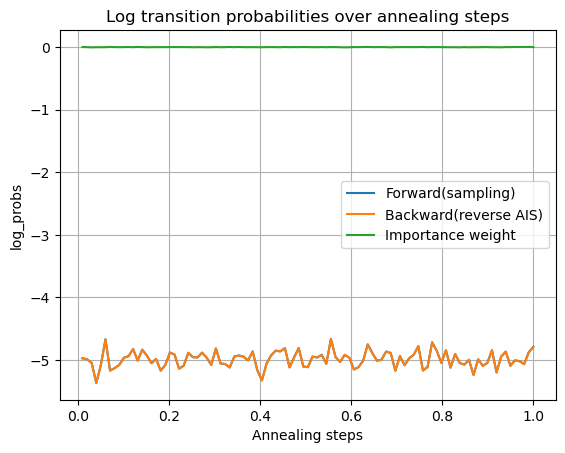

In [3]:
import torch
import matplotlib.pyplot as plt

# t 값 생성
annealing_steps = 100
t_axis = torch.linspace(0, 1, annealing_steps)[1:]

# 주어진 y 값
y_values_fwd = [-4.9740, -4.9902, -5.0488, -5.3687, -5.0832, -4.6713, -5.1700, -5.1319,
        -5.0797, -4.9655, -4.9409, -4.8262, -5.0100, -4.8363, -4.9333, -5.0529,
        -4.9851, -5.1721, -5.0822, -4.8824, -4.9135, -5.1405, -5.0926, -4.8867,
        -4.9579, -4.9601, -4.8843, -4.9647, -5.0811, -4.8158, -5.0581, -5.0662,
        -5.1205, -4.9465, -4.9287, -4.9486, -5.0082, -4.8643, -5.1656, -5.3281,
        -5.0624, -4.9271, -4.8527, -4.8643, -4.8124, -5.1193, -4.9588, -4.8104,
        -5.1063, -5.1152, -4.9473, -4.9619, -4.9178, -5.0627, -4.6645, -4.9541,
        -5.0334, -4.9204, -4.9655, -5.1535, -5.1166, -5.0140, -4.7516, -4.8900,
        -5.0139, -4.9961, -4.8664, -4.8911, -5.1740, -4.9384, -5.0845, -4.9749,
        -4.9180, -4.7796, -5.1680, -5.1155, -4.7193, -4.8546, -5.0471, -4.8477,
        -5.1245, -4.9067, -5.0496, -5.0756, -4.9992, -5.2420, -4.9914, -5.0949,
        -5.0478, -4.8463, -5.2010, -4.9488, -4.8679, -5.0941, -5.0082, -5.0196,
        -5.0669, -4.8776, -4.7905]

y_values_bwd = [-4.9768, -4.9913, -5.0463, -5.3685, -5.0829, -4.6718, -5.1743, -5.1334,
        -5.0806, -4.9670, -4.9441, -4.8263, -5.0144, -4.8386, -4.9325, -5.0540,
        -4.9859, -5.1734, -5.0834, -4.8841, -4.9163, -5.1427, -5.0943, -4.8888,
        -4.9575, -4.9612, -4.8849, -4.9639, -5.0808, -4.8188, -5.0579, -5.0674,
        -5.1244, -4.9475, -4.9326, -4.9498, -5.0087, -4.8660, -5.1660, -5.3284,
        -5.0636, -4.9293, -4.8538, -4.8645, -4.8155, -5.1201, -4.9611, -4.8116,
        -5.1099, -5.1172, -4.9476, -4.9625, -4.9203, -5.0627, -4.6668, -4.9562,
        -5.0334, -4.9179, -4.9645, -5.1560, -5.1173, -5.0174, -4.7561, -4.8916,
        -5.0156, -4.9987, -4.8679, -4.8895, -5.1756, -4.9396, -5.0872, -4.9764,
        -4.9202, -4.7818, -5.1726, -5.1161, -4.7213, -4.8574, -5.0485, -4.8478,
        -5.1240, -4.9066, -5.0475, -5.0773, -4.9982, -5.2431, -4.9910, -5.0968,
        -5.0501, -4.8462, -5.2011, -4.9473, -4.8701, -5.0954, -5.0119, -5.0232,
        -5.0714, -4.8819, -4.7921] 


y_values_weight = [ 2.7947e-03,  1.1507e-03, -2.4544e-03, -2.7012e-04, -2.2229e-04,
         4.7638e-04,  4.3355e-03,  1.4739e-03,  8.7899e-04,  1.4737e-03,
         3.2001e-03,  1.6391e-04,  4.4259e-03,  2.3737e-03, -7.8862e-04,
         1.0732e-03,  8.0614e-04,  1.3150e-03,  1.2186e-03,  1.7120e-03,
         2.8028e-03,  2.1786e-03,  1.6567e-03,  2.0816e-03, -4.5000e-04,
         1.0770e-03,  6.4372e-04, -7.8819e-04, -2.7848e-04,  2.9813e-03,
        -2.3478e-04,  1.1307e-03,  3.9271e-03,  9.9064e-04,  3.9266e-03,
         1.2417e-03,  5.4258e-04,  1.7255e-03,  3.9810e-04,  3.6515e-04,
         1.2105e-03,  2.1892e-03,  1.0851e-03,  2.4702e-04,  3.0527e-03,
         7.7470e-04,  2.3662e-03,  1.1066e-03,  3.6031e-03,  2.0836e-03,
         3.2514e-04,  5.2383e-04,  2.4850e-03,  7.8925e-06,  2.2570e-03,
         2.0553e-03,  4.7284e-06, -2.5743e-03, -1.0584e-03,  2.5416e-03,
         7.4910e-04,  3.4036e-03,  4.4718e-03,  1.6543e-03,  1.6329e-03,
         2.5190e-03,  1.4883e-03, -1.6265e-03,  1.6121e-03,  1.1978e-03,
         2.7663e-03,  1.5443e-03,  2.1252e-03,  2.1819e-03,  4.5349e-03,
         5.6907e-04,  2.0025e-03,  2.8004e-03,  1.3705e-03,  5.7698e-05,
        -4.0706e-04, -1.3136e-04, -2.0582e-03,  1.7380e-03, -1.0169e-03,
         1.0903e-03, -3.7333e-04,  1.9142e-03,  2.2840e-03, -1.9455e-04,
         5.7546e-05, -1.4473e-03,  2.2341e-03,  1.3076e-03,  3.7389e-03,
         3.6256e-03,  4.4977e-03,  4.3260e-03,  1.6794e-03]
# 플로팅
plt.plot(t_axis.numpy(), y_values_fwd, label='Forward(sampling)')
plt.plot(t_axis.numpy(), y_values_bwd, label='Backward(reverse AIS)')
plt.plot(t_axis.numpy(), y_values_weight, label='Importance weight')


plt.xlabel('Annealing steps')
plt.ylabel('log_probs')
plt.title('Log transition probabilities over annealing steps')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
import torch

# Toy example parameters
dt = 0.01
sigma = 0.1
forward_drift = 0.5
bwd_drift = -0.5
x = torch.tensor([[1.0]])  # Initial position
device = x.device

# Euler-Maruyama update for X_{t+1}
x_new = x + forward_drift * dt + sigma * torch.sqrt(torch.tensor(2 * dt)) * torch.randn_like(x)

# Forward and backward mean
mean_fwd = x + forward_drift * dt
mean_bwd = x_new + bwd_drift * dt

# Variance
variance = (sigma ** 2) * 2 * dt

# Using your function
def compute_transition_log_prob(x, x_new, transition_mean, transition_std, bwd_drift): #Fix_backwards
    variance = torch.tensor(transition_std**2, device=x.device)
    
    # Compute the log probability of x_{t+1} under the Gaussian transition from x_t
    log_p_transition_fwd = (
        -((x - transition_mean) ** 2).sum(dim=-1) / (2 * variance) 
        - 0.5 * x.shape[1] * torch.log(2 * torch.pi * variance)
    )
    
    log_p_transition_bwd = (
        -((x_new + bwd_drift) ** 2).sum(dim=-1) / (2 * variance) 
        - 0.5 * x.shape[1] * torch.log(2 * torch.pi * variance)
    )   
    
    log_importance_weight = log_p_transition_fwd - log_p_transition_bwd
    
    return log_p_transition_fwd, log_p_transition_bwd, log_importance_weight

# Test the function
transition_std = sigma * torch.sqrt(2 * dt)
log_p_fwd, log_p_bwd, log_importance_weight = compute_transition_log_prob(x, x_new, mean_fwd, transition_std, bwd_drift)

print("Log Forward Transition Probability:", log_p_fwd)
print("Log Backward Transition Probability:", log_p_bwd)
print("Log Importance Weight:", log_importance_weight)


TypeError: sqrt(): argument 'input' (position 1) must be Tensor, not float